# Homework 4

## Question 1: Propensity score matching


In this exercise, you will apply propensity score matching, which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "Evaluating the Econometric Evaluations of Training Programs" (1986). The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. Your task is to determine the effectiveness of the "treatment" represented by the job training program.

Dataset description

 - treat: 1 if the subject participated in the job training program, 0 otherwise
 - age: the subject's age
 - educ: years of education
 - race: categorical variable with three possible values: Black, Hispanic, or White
 - married: 1 if the subject was married at the time of the training program, 0 otherwise
 - nodegree: 1 if the subject has earned no school degree, 0 otherwise
 - re74: real earnings in 1974 (pre-treatment)
 - re75: real earnings in 1975 (pre-treatment)
 - re78: real earnings in 1978 (outcome)
 

## 1.1 A naive analysis

Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

## Solution


Our approach is blah blah blah....

In [1]:
%matplotlib inline
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import networkx as nx

In [2]:
file_path = '../lalonde.csv'

def read_data(file_name):
    df = pd.DataFrame()
    df = df.append( pd.read_csv(file_name, sep=","))
    return df

propensity_df = read_data(file_path)
propensity_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


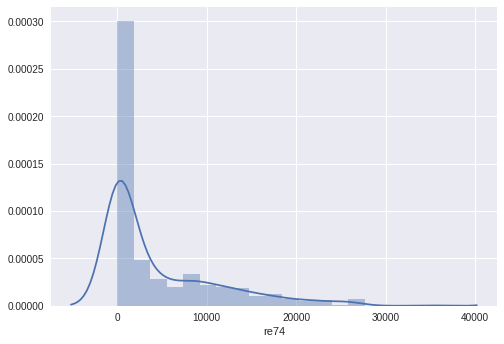

In [3]:
sns.distplot(propensity_df['re74'])

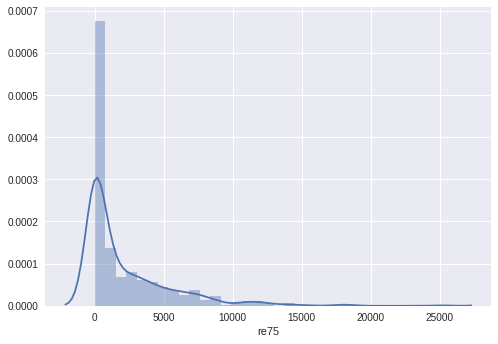

In [4]:
sns.distplot(propensity_df['re75'])

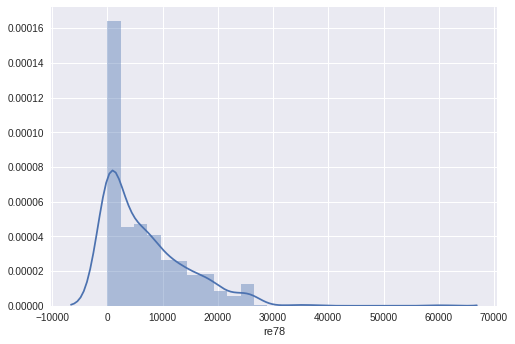

In [5]:
sns.distplot(propensity_df['re78'])
#propensity_df['re78']

In [6]:
propensity_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


## Explanation

This graphs are positive skew. 

In [7]:
# chech covariance? 

propensity_df.corr()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
treat,1.000000,-0.102893,0.019308,0.600907,-0.117983,-0.301334,0.105857,-0.249779,-0.130197,-0.039033
age,-0.102893,1.000000,-0.125622,-0.110730,-0.053400,0.376059,-0.069218,0.333254,0.140022,0.106249
educ,0.019308,-0.125622,1.000000,-0.010528,-0.174153,-0.095051,-0.701452,0.136583,0.018301,0.161538
black,0.600907,-0.110730,-0.010528,1.000000,-0.294973,-0.317118,0.109278,-0.257334,-0.140374,-0.120977
hispan,-0.117983,-0.053400,-0.174153,-0.294973,1.000000,0.021549,0.100869,-0.007091,0.061589,0.015325
married,-0.301334,0.376059,-0.095051,-0.317118,0.021549,1.000000,-0.032349,0.425739,0.353824,0.162358
nodegree,0.105857,-0.069218,-0.701452,0.109278,0.100869,-0.032349,1.000000,-0.208751,-0.070412,-0.142418
re74,-0.249779,0.333254,0.136583,-0.257334,-0.007091,0.425739,-0.208751,1.000000,0.552002,0.343416
re75,-0.130197,0.140022,0.018301,-0.140374,0.061589,0.353824,-0.070412,0.552002,1.000000,0.257659
re78,-0.039033,0.106249,0.161538,-0.120977,0.015325,0.162358,-0.142418,0.343416,0.257659,1.000000


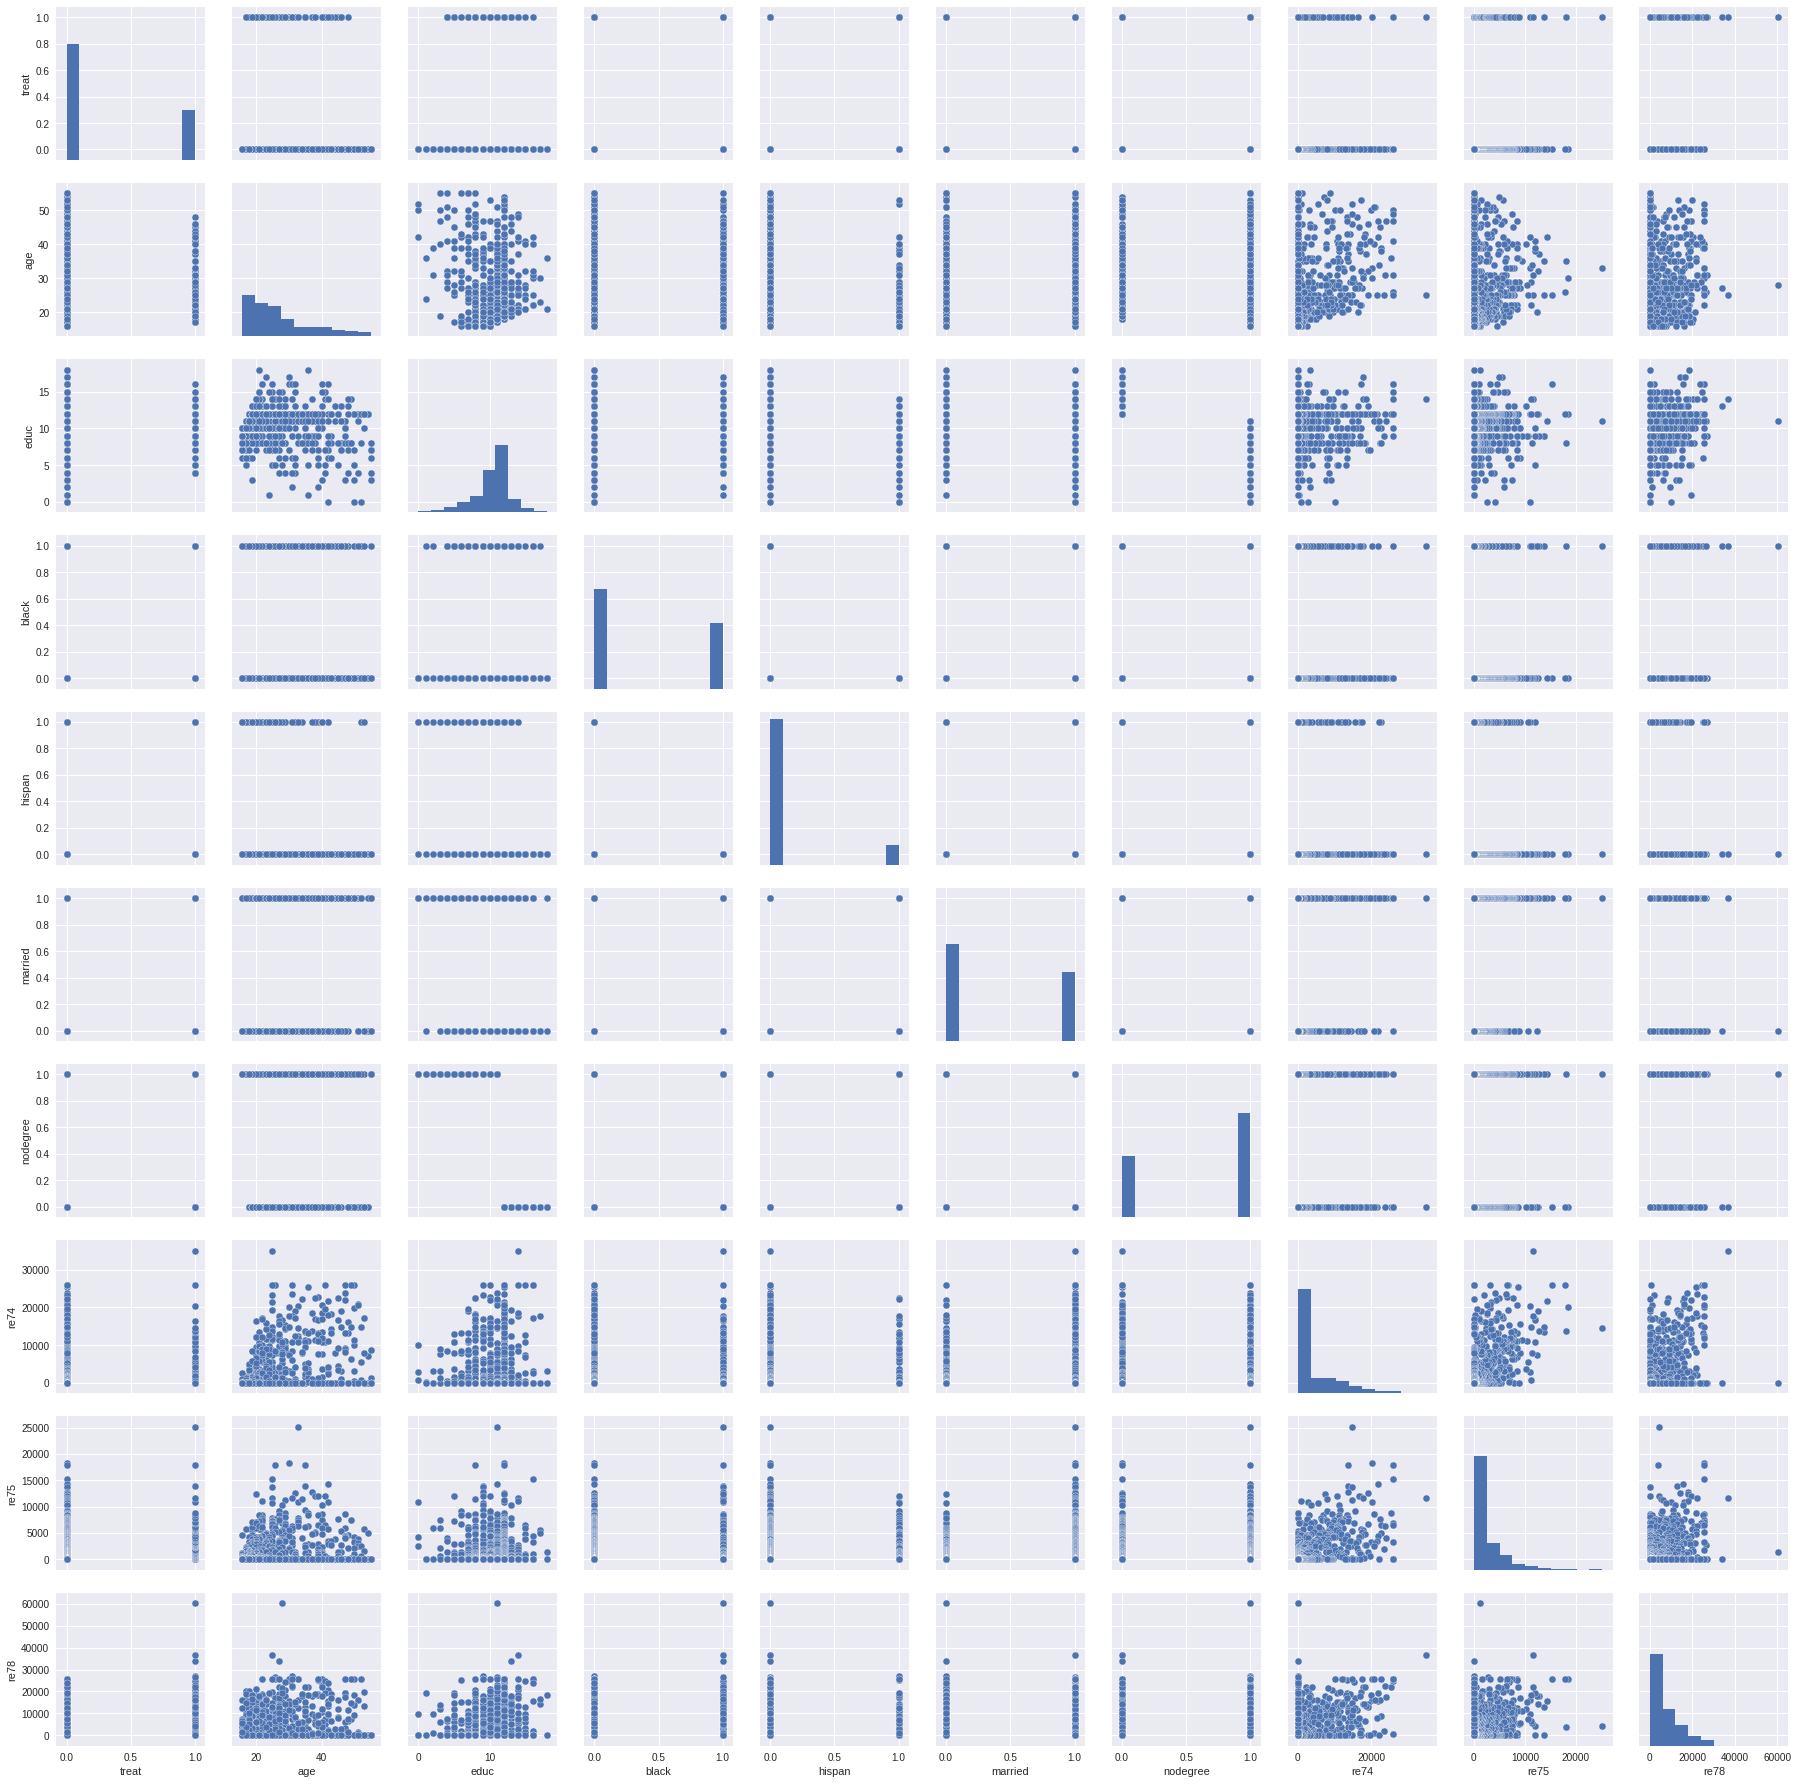

In [8]:
sns.pairplot(propensity_df)

In [9]:
# with sns.axes_style("white"):
#     sns.jointplot(x=, y=propensity_df[], kind="hex", color="k");

## 1.2 A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above. You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

## Solution




In [10]:
# split the data to threated and control group
treated_group_df = propensity_df.query('treat == 1')
print (treated_group_df.shape)
control_group_df = propensity_df.query('treat == 0')
print (control_group_df.shape)


(185, 11)
(429, 11)


In [11]:
treated_group_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [12]:
control_group_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
185,PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67
186,PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67
187,PSID3,0,25,16,0,0,1,0,25862.32,15316.21,25564.67
188,PSID4,0,42,11,0,0,1,1,21787.05,14265.29,15491.01
189,PSID5,0,25,9,1,0,1,1,14829.69,13776.53,0.00


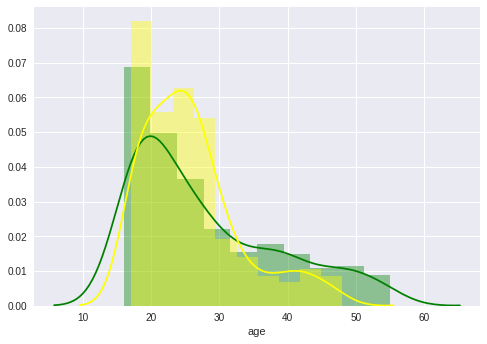

In [13]:
# comparing the distributions of the age

sns.distplot(control_group_df['age'], color = 'green')
sns.distplot(treated_group_df['age'], color = 'yellow')

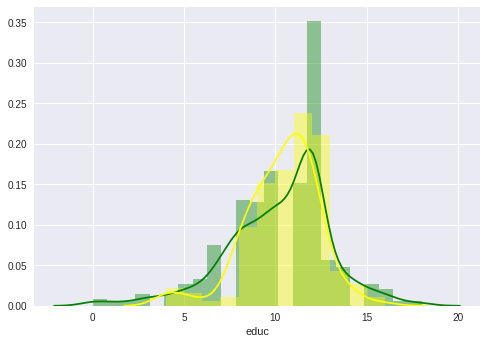

In [14]:
# comparing distributions of the education

sns.distplot(control_group_df['educ'], color = 'green')
sns.distplot(treated_group_df['educ'], color = 'yellow')

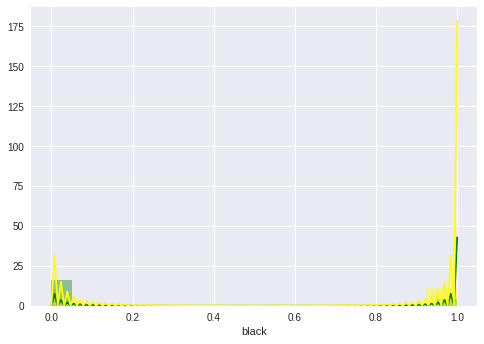

In [15]:
# comparing the distributions of race

sns.distplot(control_group_df['black'], color = 'green')
sns.distplot(treated_group_df['black'], color = 'yellow')

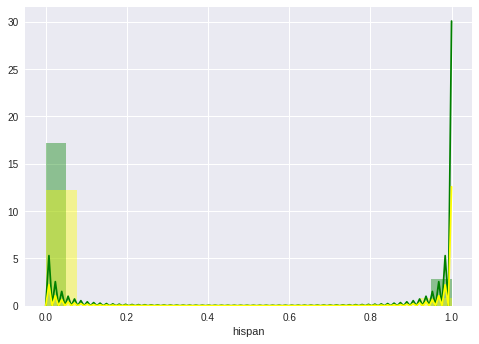

In [16]:
# hispan distributions 

sns.distplot(control_group_df['hispan'], color = 'green')
sns.distplot(treated_group_df['hispan'], color = 'yellow')

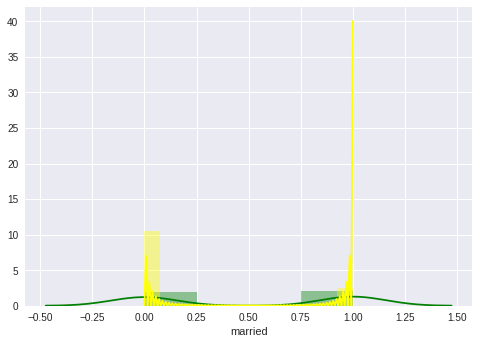

In [17]:
# comparing married distribution

sns.distplot(control_group_df['married'], color = 'green')
sns.distplot(treated_group_df['married'], color = 'yellow')

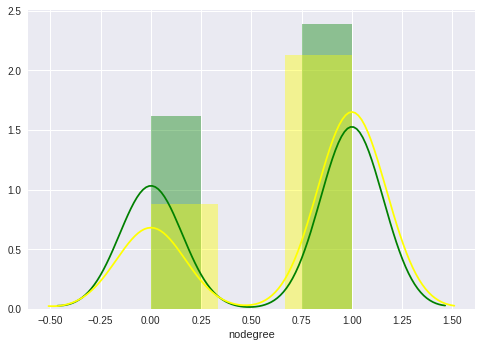

In [18]:
# comparing the distributions of the 

sns.distplot(control_group_df['nodegree'], color = 'green')
sns.distplot(treated_group_df['nodegree'], color = 'yellow')

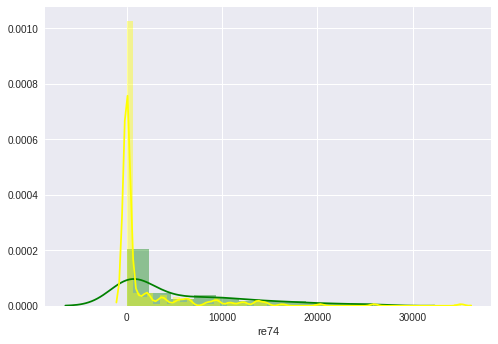

In [19]:
# comparing the distributions of the salary in 1974.

sns.distplot(control_group_df['re74'], color = 'green')
sns.distplot(treated_group_df['re74'], color = 'yellow')

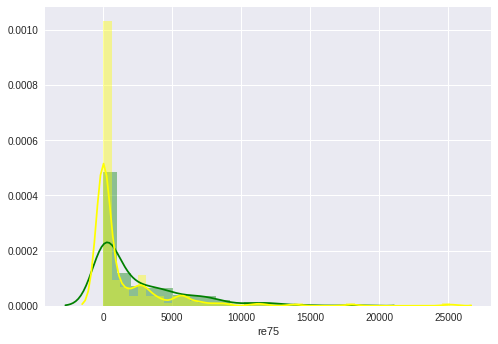

In [20]:
# comparing the distributions of the salary in 1975.

sns.distplot(control_group_df['re75'], color = 'green')
sns.distplot(treated_group_df['re75'], color = 'yellow')

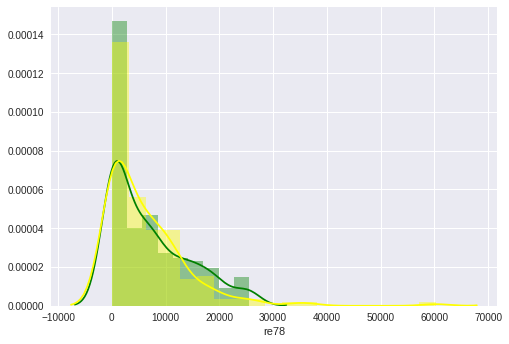

In [21]:
# comparing the distributions of the salary in 1978.

sns.distplot(control_group_df['re78'], color = 'green')
sns.distplot(treated_group_df['re78'], color = 'yellow')

## 1.3 Propensity score

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


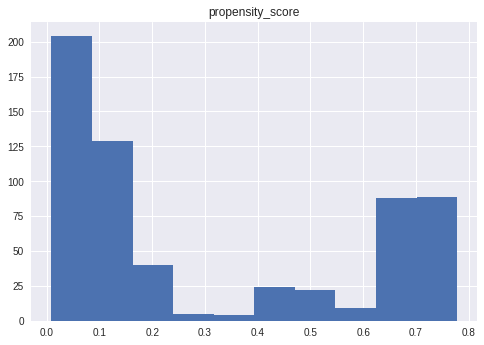

In [22]:
features =  ['age','educ','black','hispan','married','nodegree','re74','re75']

def lin_regress(df):
    logistic = linear_model.LogisticRegression()
    x = df[features]
    y = df['treat']
    #plt.plot(x,y,'ro')
    #plt.show()
    logistic.fit(x,y)
    res = logistic.predict_proba(x)
    return res


res = lin_regress(propensity_df)
df = propensity_df.copy()
df['propensity_score'] = res[:,1]
df.hist(['propensity_score'])
df.head()

## Balancing the dataset via matching

Quote: https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view


"In doing so, several decisions must be made. First, one must choose between matching without replacement and matching with replacement (Rosenbaum, 2002)."


In [23]:
def match_propensity_score(df):
    df_treat = df.query('treat == 1')
    df_control = df.query('treat == 0')
    
    graph = nx.Graph()
    edges = [(id_x, id_y, {'weight': 1 - np.abs(x['propensity_score'] - y['propensity_score'])}) \
         for (id_x, x) in df_treat.iterrows() for (id_y, y) in df_control.iterrows()]
    graph.add_edges_from(edges)
    matching = nx.max_weight_matching(graph, maxcardinality=True)
    return matching, graph

In [24]:
match, graph = match_propensity_score(df)

In [71]:
matched_df = df[df.index.isin(list(match))]
matched_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


In [72]:
# now let's plot this for matched data
treated_matched_df = matched_df.query("treat == 1")
control_matched_df = matched_df.query("treat == 0 ")

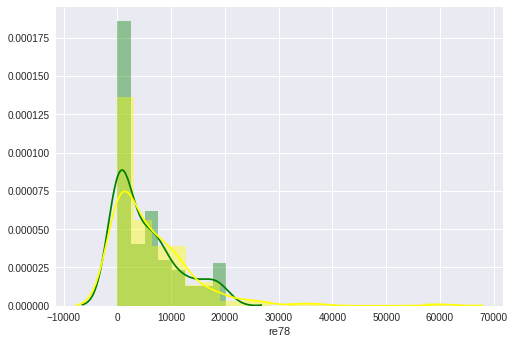

In [73]:
sns.distplot(control_matched_df['re78'], color = 'green')
sns.distplot(treated_matched_df['re78'], color = 'yellow')

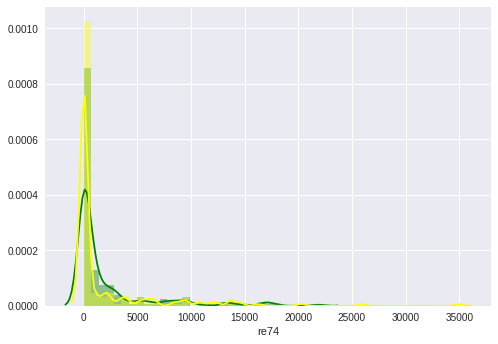

In [28]:
sns.distplot(control_matched_df['re74'], color = 'green')
sns.distplot(treated_matched_df['re74'], color = 'yellow')

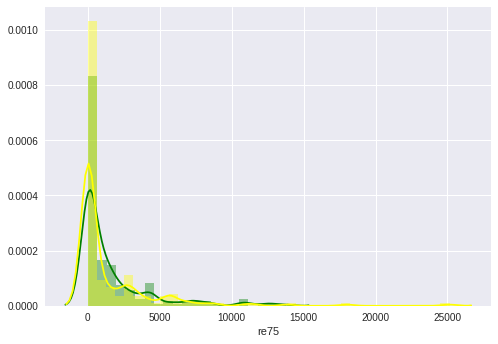

In [29]:
sns.distplot(control_matched_df['re75'], color = 'green')
sns.distplot(treated_matched_df['re75'], color = 'yellow')

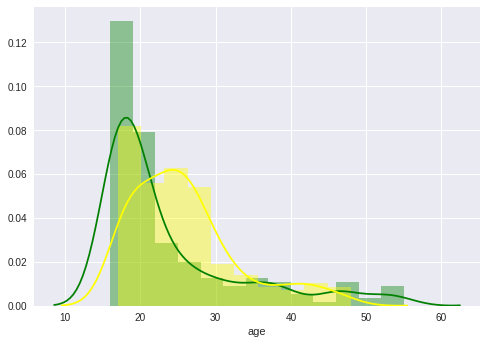

In [30]:
sns.distplot(control_matched_df['age'], color = 'green')
sns.distplot(treated_matched_df['age'], color = 'yellow')

In [31]:
# TODO: insert observations - this doesn't look ok to me
# TODO: add more bar plots with explanations for each

In [59]:
# see for keys in match what is the distribution, and for values
# because I am not sure if we should take treated and non-treated people? 

# propensity matching with this algorithm was not really good for some values, as seen here:
for key in match:
    print (key, ": ", match[key])
    print (df.ix[key].propensity_score," : " , df.ix[match[key]].propensity_score)
    
    

104 :  572
0.676164197777  :  0.676164197777
572 :  104
0.676164197777  :  0.676164197777
103 :  424
0.677650114261  :  0.146030561806
558 :  163
0.677650114261  :  0.72861855959
91 :  581
0.693346203761  :  0.155029530268
576 :  116
0.693346203761  :  0.69752067861
60 :  560
0.720683519339  :  0.720683519339
560 :  60
0.720683519339  :  0.720683519339
55 :  585
0.693346203761  :  0.693346203761
585 :  55
0.693346203761  :  0.693346203761
52 :  573
0.677650114261  :  0.677650114261
573 :  52
0.677650114261  :  0.677650114261
46 :  582
0.720683519339  :  0.720683519339
582 :  46
0.720683519339  :  0.720683519339
33 :  514
0.735773101844  :  0.634834859894
557 :  170
0.735773101844  :  0.741176448601
24 :  551
0.691899744442  :  0.691899744442
551 :  24
0.691899744442  :  0.691899744442
11 :  565
0.721375959564  :  0.721375959564
565 :  11
0.721375959564  :  0.721375959564
452 :  175
0.711895603965  :  0.716127957409
152 :  555
0.711894634936  :  0.15020312539
456 :  21
0.137654812676  :

In [69]:
# now we will do the matching on foot
# exclude all these keys where we have difference in the first decimal
match_copy = match.copy()

# go trough match, but remove from match_copy because you can't remove
# and iterate through same dict

for key in match:
    #print (key, ": ", match_copy[key])
    v1 = df.ix[key].propensity_score
    v2 = df.ix[match_copy[key]].propensity_score
    #print (v1," : " , v2)
    if (np.abs(v1-v2) > 0.09):
        #print ("delete this one")
        del match_copy[key]
        
print (len(match_copy))

204


## TODO: 

Explain what we did on foot, and now let's see how this affects our distributions:

In [74]:
processed_matched_df = df[df.index.isin(list(match_copy))]
treated_processed_matched_df = processed_matched_df.query("treat == 1")
control_processed_matched_df = processed_matched_df.query("treat == 0")



In [78]:
treated_processed_matched_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286
5,NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0.700118


In [79]:
control_processed_matched_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
192,PSID8,0,20,12,1,0,0,0,7392.3140,12396.190,17765.230,0.765043
199,PSID15,0,22,14,1,0,1,0,748.4399,11105.370,18208.550,0.650250
208,PSID24,0,47,8,1,0,1,1,9275.1690,8543.419,0.000,0.424355
224,PSID40,0,40,3,0,1,1,1,7576.4850,7426.258,12104.060,0.076671
225,PSID41,0,22,12,1,0,1,0,9729.7190,7372.548,2231.367,0.465022


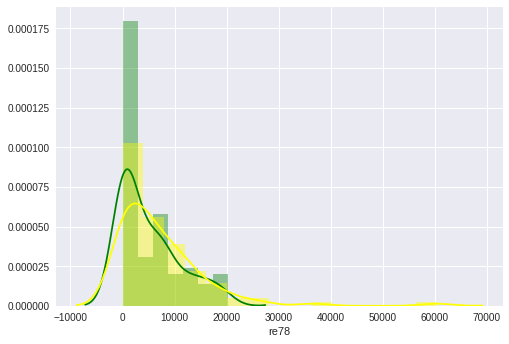

In [82]:
sns.distplot(control_processed_matched_df['re78'], color = 'green')
sns.distplot(treated_processed_matched_df['re78'], color = 'yellow')

In [84]:
## TODO: observations

# Question 2 - Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!


## Task 1.


Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn (link).
TF-IDF, short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using TfidfVectorizer. Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).



## Solution





In [129]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [87]:
t = fetch_20newsgroups()

In [90]:
dataset = t

In [94]:
# targets
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [106]:
# number of e-mails 11314
len(dataset.data) 

11314

In [109]:
tfidf = TfidfVectorizer(dataset.data)

In [113]:
vectors = tfidf.fit_transform(dataset.data)

In [121]:
x = vectors
y = dataset.target
x, x_test, y, y_test = train_test_split(x, y, test_size=0.1, train_size=0.9, random_state=1)

In [124]:
s = ShuffleSplit(n_splits=2, test_size=0.1111, random_state=0)

In [125]:
param_grid = {
                 'n_estimators': np.arange(80, 100, 10),
                 'max_depth': [20]
             }

In [130]:
rfc = RandomForestClassifier()

In [131]:
rfc_gridsearch = GridSearchCV(rfc, param_grid=param_grid, verbose=2, cv=s)

In [134]:
rfc_gridsearch.fit(x, y)
print(rfc_gridsearch.best_params_)
results = pd.DataFrame(rfc_gridsearch.cv_results_)
results.to_csv(path_or_buf='data/results_gridsearch.csv', encoding='utf8')

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] max_depth=20, n_estimators=80 ...................................
[CV] .................... max_depth=20, n_estimators=80, total=   6.4s
[CV] max_depth=20, n_estimators=80 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] .................... max_depth=20, n_estimators=80, total=   6.1s
[CV] max_depth=20, n_estimators=90 ...................................
[CV] .................... max_depth=20, n_estimators=90, total=   7.0s
[CV] max_depth=20, n_estimators=90 ...................................
[CV] .................... max_depth=20, n_estimators=90, total=   7.2s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   30.3s finished


{'max_depth': 20, 'n_estimators': 80}


In [135]:
rfc.set_params(n_estimators=100, max_depth=20)
rfc.fit(x, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [137]:
y_pred = rfc.predict(x_test)
accuracy_score(y_pred, y_test)

0.79063604240282681

In [139]:
print(classification_report(y_test, y_pred, target_names=dataset.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.78      0.74      0.76        54
           comp.graphics       0.74      0.70      0.72        57
 comp.os.ms-windows.misc       0.68      0.88      0.77        59
comp.sys.ibm.pc.hardware       0.76      0.69      0.72        70
   comp.sys.mac.hardware       0.88      0.75      0.81        61
          comp.windows.x       0.84      0.82      0.83        57
            misc.forsale       0.65      0.86      0.74        72
               rec.autos       0.81      0.80      0.80        49
         rec.motorcycles       0.90      0.88      0.89        51
      rec.sport.baseball       0.82      0.82      0.82        51
        rec.sport.hockey       0.88      0.94      0.91        53
               sci.crypt       0.81      0.96      0.88        54
         sci.electronics       0.74      0.58      0.65        59
                 sci.med       0.88      0.80      0.84        55
         